## Combine PubMed text embeddings and SMILES embeddings to classify BBBP

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,

)

import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

### Load training datasets

In [ ]:
names_train_df = pd.read_csv("https://staicentreprod001.blob.core.windows.net/share/mlprague23/B3DB_cleaned_name_TRAIN.csv")
smiles_train_df = pd.read_csv("https://staicentreprod001.blob.core.windows.net/share/mlprague23/B3DB_cleaned_SMILES_TRAIN.csv")

In [ ]:
sample_size=1000
names_samp_df = names_train_df.sample(n=sample_size, replace=False)
smiles_samp_df = smiles_train_df.sample(n=sample_size, replace=False)

In [ ]:
smiles_samp_df.head()

,SMILES,label,split
554,CCCC(=O)O[C@]1(C(=O)COC(=O)CC)CC[C@H]2[C@@H]3C...,1,TRAIN
412,CC(=O)C1(O)CCC2C3CC(C)C4=CC(=O)CCC4(C)C3CCC21C,0,TRAIN
248,COc1cccc(C(=O)NC2C[C@@H]3CC[C@H](C2)N3Cc2ccccc...,1,TRAIN
405,COc1ccc(OC[C@H]2CN(C)CCC2c2ccccc2)cc1,1,TRAIN
3314,CN(C(=O)Cc1ccc(Cl)c(Cl)c1)[C@H](CN1CCCC1)c1ccccc1,1,TRAIN


In [ ]:
mol_labels = pd.concat([names_samp_df, smiles_samp_df]).label
mol_labels

2993    1
3302    1
2779    1
2971    1
383     1
       ..
1484    0
1035    1
2274    0
925     1
3207    1
Name: label, Length: 2000, dtype: int64

#### Get SMILES embeddings

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
smile_ids = tokenizer(smiles_samp_df.SMILES.to_list(), padding=True, truncation=True, return_tensors='pt')

model = AutoModelForMaskedLM.from_pretrained("seyonec/ChemBERTa-zinc-base-v1", output_hidden_states=True)
model.eval();

with torch.no_grad():
    output_mols = model(**smile_ids)
hidden_states = output_mols[1]
smiles_embedding = torch.mean(hidden_states[-1], dim=1).squeeze()

#### Get text embeddings

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
mol_ids = tokenizer(names_samp_df.name.to_list(), padding=True, truncation=True, max_length=10, return_tensors='pt')

model = AutoModelForMaskedLM.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext", output_hidden_states=True)
model.eval();

with torch.no_grad():
    output_mols = model(**mol_ids)

hidden_states = output_mols[1]
text_embedding = torch.mean(hidden_states[-1], dim=1).squeeze()

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Concatenate embeddings

In [ ]:
txtSML_embed = torch.cat((text_embedding, smiles_embedding), dim=0)
print(txtSML_embed.size())

torch.Size([2000, 768])


In [ ]:
# convert the tensor to numpy
X_train, X_test, y_train, y_test = train_test_split(
    txtSML_embed.numpy(),
    mol_labels.to_numpy().astype('int'),
    test_size=0.2,
    random_state=42,
)

In [ ]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = classifier.predict(X_test)

print("Test accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test, y_pred, digits=2))

Test accuracy: 0.78
              precision    recall  f1-score   support

           0       0.72      0.39      0.51       117
           1       0.79      0.94      0.86       283

    accuracy                           0.78       400
   macro avg       0.75      0.66      0.68       400
weighted avg       0.77      0.78      0.75       400



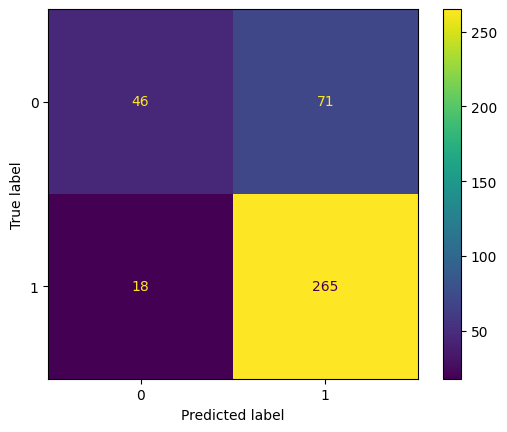

In [ ]:
print(ConfusionMatrixDisplay.from_predictions(y_test, y_pred))